In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Functions

In [9]:
historical_features = pd.read_csv("internal_files/historical_features.csv", parse_dates=["Date"], index_col="Date")
historical_features["month"] = historical_features.index.month
historical_month_dummies = pd.get_dummies(historical_features["month"], prefix="Month", drop_first=True)

future_data = pd.read_csv("internal_files/future_data.csv", parse_dates=["Date"], index_col="Date")
future_data["month"] = future_data.index.month
future_month_dummies = pd.get_dummies(future_data["month"], prefix="Month", drop_first=True)

# load the EMS output file from the specified directory
files_in_folder = os.listdir("ems_output")

if len(files_in_folder) == 0:
    raise ValueError(f"No files found in the folder: ems_output")
elif len(files_in_folder) > 1:
    raise ValueError(f"Multiple files found in the folder: ems_output. Please ensure only one file is present.")
if not files_in_folder[0].endswith(".xlsx"):
    raise ValueError(f"The file in the folder: ems_output is not an Excel file. Please ensure the file is an Excel file.")

# Extract the file name without extension (remove last 5 characters)
file_name = files_in_folder[0][:-5]
ems_output_path = os.path.join("ems_output", files_in_folder[0])

revenues_df = pd.read_excel(f'{ems_output_path}', index_col=0, header=0).T
revenues_df.index = pd.to_datetime(revenues_df.index, format="%Y-%m-%d")
revenues_df = revenues_df.iloc[:, 8:14]
revenues_df["Imbalance"] = revenues_df.iloc[:, 2] + revenues_df.iloc[:, 3]
revenues_df["Day-ahead"] = revenues_df.iloc[:, 0] + revenues_df.iloc[:, 1]
revenues_df["Intraday"] = revenues_df.iloc[:, 4] + revenues_df.iloc[:, 5]
revenues_df["Total"] = revenues_df["Day-ahead"] + revenues_df["Intraday"] + revenues_df["Imbalance"]

revenues_df = revenues_df.iloc[:, 6:]
revenues_df = revenues_df.resample("ME").sum()

# add revenues_df as columns to historical_data
historical_data = pd.concat([historical_features, revenues_df], axis=1)

def train_model(outcome, feature_names=["RESP", "NG_Price", "BESS"], show_summary=True, scale=True):
    """ 
    Trains a Ridge regression model using historical data and specified features.
    - Parameters:
        - feature_names: List of feature names to be used in the model.
        - outcome: The target variable to predict.
        - historical_data_path: Path to the historical data CSV file.
        - show_summary: Boolean to display model summary.
        - scale: Boolean to apply feature scaling.
        - ems_output_path: Path to the EMS output Excel file.
    """
    # Features and target
    X = pd.concat([historical_data[feature_names], historical_month_dummies], axis=1).astype(float)
    y = historical_data[outcome]

    # Remove outliers
    z = np.abs(stats.zscore(y))
    threshold = 3
    outliers = np.where(z > threshold)[0]
    X = X.drop(X.index[outliers])
    y = y.drop(y.index[outliers])

    #Feature scaling
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X_scaled = scaler.fit_transform(X)
        X_const = sm.add_constant(X_scaled)
    else:
        X_const = sm.add_constant(X)
        scaler=None

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    model = RidgeCV(cv=tscv, store_cv_results=False, alphas=np.logspace(-3, 3, 100)).fit(X_const, y)

    # Best model metrics
    best_alpha = model.alpha_
    y_pred = model.predict(X_const)
    mae = mean_absolute_error(y, y_pred)

    #HISTORICAL RESIDUALS
    residuals = y - y_pred

    if show_summary:
        print(f"✅ Best Alpha: {best_alpha}")
        print(f"✅ Mean Absolute Error on Full Data: {mae:.4f}")

    return model, residuals, scaler

def forecast_with_scenarios(model, residuals, scaler, outcome, show_plot=True, add_volatility=True):
    """
    Forecasts future scenarios using the trained model and specified features, including monthly dummies. May incroporate volatility by adjusting forecasts based on historical residuals.
    Parameters:
    - model: Trained Ridge regression model.
    - residuals: Historical residuals from the model.
    - scaler: StandardScaler object for feature scaling.
    - outcome: The target variable to predict.
    - feature_names: List of feature names to be used in the model.
    - future_data_path: Path to the future data CSV file.
    - historical_data_path: Path to the historical data CSV file.
    - show_plot: Boolean to display the forecast plot.
    - add_volatility: Boolean to add volatility to the forecast based on historical residuals.
    """

    scenario_mapping = {
        "RESP": ["Ra", "Rb", "Rc", "Rd", "Re", "Rf"],
        "NG_Price": ["Ga", "Gb", "Gc"],
        "BESS": ["Ba", "Bb", "Bc", "Bd", "Be", "Bf"],
    }

    scenario_combinations = list(itertools.product(
        *[scenario_mapping[key] for key in scenario_mapping.keys()]
    ))

    # Get the standard deviation of the residuals to incorporate volatility
    residuals_std = residuals.std()

    future_combination_dfs = []

    for combination in scenario_combinations:
        combination_name = "_".join(combination)

        try:
            # Base features
            temp_df = pd.DataFrame({
                "RESP": future_data[combination[0]].values,
                "NG_Price": future_data[combination[1]].values,
                "BESS": future_data[combination[2]].values,
            })

            temp_df.index = future_data.index

            # Combine with month dummies
            X_future = pd.concat([temp_df, future_month_dummies], axis=1).astype(float)
            
            if scaler == None:
                x_future_scaled = sm.add_constant(X_future).astype(float)
            else:
                x_future_scaled = scaler.transform(X_future)
                x_future_scaled = sm.add_constant(x_future_scaled).astype(float)

            # Predict revenue
            revenue_forecast = model.predict(x_future_scaled)

            if add_volatility:
                # Adjust forecast for volatility (adding/subtracting based on residual std)
                adjusted_forecast = revenue_forecast + residuals_std * np.random.randn(len(revenue_forecast))
            else:
                adjusted_forecast = revenue_forecast

            # Store forecast
            future_comb_df = pd.DataFrame({
                "Date": future_data.index,
                f"Total Revenue Forecast ({combination_name})": adjusted_forecast
            })
            future_combination_dfs.append(future_comb_df.set_index("Date"))

        except KeyError as e:
            print(f"Missing column in combination {combination}: {e}")
            continue

    all_forecasts = pd.concat(future_combination_dfs, axis=1)

    if show_plot:
        plt.figure(figsize=(20, 5))
        plt.plot(historical_data.index, historical_data[outcome], label="Historical Revenue")
        for column in all_forecasts.columns:
            plt.plot(all_forecasts.index, all_forecasts[column], label=column)
        plt.title(f"Forecasts for {outcome} Revenue Across Scenarios")
        plt.grid(True)
        plt.show()

    return all_forecasts

def create_annualized_forecast(scenarios, low_factors, mid_factors, high_factors, tipping_points, summed_monthly_forecasts, 
                               show_monthly_plots=False, print_selected_monthly_scenarios=False, add_montel_curves=False):
    """
    Creates annualized, and monthly forecasts for different scenarios based on specified factors with index year of 2025.
    - Parameters:
        - scenarios: List of scenario names (e.g., ["low", "mid", "high"])
        - low_factors, mid_factors, high_factors: Lists of factors for each scenario
        - tipping_points: List of tipping points (dates) for adjustments
        - save_folder: Folder to save the results
        - show_monthly_plots: Boolean to show monthly plots
        - add_montel_curves: Boolean to add Montel curves to the plot
        - save_results: Option to save results as "small" or "large"
        - print_selected_monthly_scenarios: Boolean to print selected monthly scenarios
        - c_rate: A parameter for the model (default is 0.5)
    """
    highlight_ranges = [
        ('2025-01-01', '2028-01-01', 'lightgreen'),
        ('2028-01-01', '2032-01-01', 'lightpink'),
        ('2032-01-01', '2051-01-01', 'lightblue')
    ]
    selected_scenarios = pd.DataFrame()
    # create 2 dimensional array
    scenario_factors = np.zeros((len(scenarios), 3))

    for scenario in enumerate(scenarios):
        # split the scenario name into its components
        scenario_components = scenario[1].split("_")

        if scenario_components[0] == "low":
            scenario_factors[scenario[0]][0] = low_factors[0]

        elif scenario_components[0] == "mid":
            scenario_factors[scenario[0]][0] = mid_factors[0]

        elif scenario_components[0] == "high":
            scenario_factors[scenario[0]][0] = high_factors[0]

        if len(scenario_components) > 1:
            if scenario_components[1] == "low":
                scenario_factors[scenario[0]][1] = low_factors[1]

            elif scenario_components[1] == "mid":
                scenario_factors[scenario[0]][1] = mid_factors[1]

            elif scenario_components[1] == "high":
                scenario_factors[scenario[0]][1] = high_factors[1]

        if len(scenario_components) > 2:
            if scenario_components[2] == "low":
                scenario_factors[scenario[0]][2] = low_factors[2]

            elif scenario_components[2] == "mid":
                scenario_factors[scenario[0]][2] = mid_factors[2]

            elif scenario_components[2] == "high":
                scenario_factors[scenario[0]][2] = high_factors[2]

    dict = {}
    monthly_forecasts = summed_monthly_forecasts

    for scenario in enumerate(scenarios):
        monthly_forecasts_adjusted = smooth_tipping_adjustment(monthly_forecasts, tipping_points, scenario_factors[scenario[0]], width_years=4)

        monthly_reference = monthly_forecasts_adjusted.groupby(monthly_forecasts_adjusted.index.month).transform("first")
        forecast_data_percentage = monthly_forecasts_adjusted / monthly_reference

        if show_monthly_plots:
            plt.figure(figsize=(20, 5))

            for column in forecast_data_percentage.columns:
                current_forecast = forecast_data_percentage[forecast_data_percentage.index.year != 2025]
                plt.plot(current_forecast.index, current_forecast[column] * 100, label=column)

            for start, end, color in highlight_ranges:
                plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color=color, alpha=0.2)

            plt.title(f"Monthly Revenues as % of 2025 Revenues for Scenario: {scenario[1]}")
            plt.xlabel("Date")
            plt.ylabel("Percentage Change")
            plt.show()

        # set seed
        np.random.seed(42)
        
        take = []
        for i in range(10):
            # append random number to take
            take.append(np.random.randint(0, len(forecast_data_percentage.columns)))
        
        selected_columns = forecast_data_percentage.iloc[:, take]
        selected_scenarios = pd.concat([selected_scenarios, selected_columns], axis=1)

        # Resample to yearly data using sum
        yearly_revenue = monthly_forecasts_adjusted.resample('YE').sum()

        # Convert the Date index to the year format
        yearly_revenue.index = yearly_revenue.index.year

        # Select the base year (2025)
        base_year = yearly_revenue.iloc[0]
        base_year_values = base_year.values

        # Calculate percentage change compared to 2025
        percentage_change = (yearly_revenue / base_year_values) * 100

        dict[scenario[0]] = percentage_change
        print(f"Scenario {scenario[1]} processed.")

    selected_scenarios.to_csv(f"forecast_output/forecast_{file_name}.csv", index=True, header=True)
    selected_scenarios.T.to_excel(f"forecast_output/forecast_{file_name}.xlsx", index=True, header=True)

    plt.figure(figsize=(20, 5))

    # create series of years between 2025 and 2050
    years = pd.date_range(start="2025-01-01", end="2051-01-01", freq="YE")

    for scenario in dict.keys():
        scenario_data = dict[scenario]
        scenario_data.index = pd.to_datetime(years, format="%Y")

        for column in scenario_data.columns:
            plt.plot(scenario_data.index, scenario_data[column], linewidth=0.5, label=column, alpha=0.5)

    for start, end, color in highlight_ranges:
        plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color=color, alpha=0.2)

    if add_montel_curves:
        std_montel = pd.read_csv("internal_files/standardized_scenarios_montel.csv", parse_dates=["Year"])
        std_montel.set_index("Year", inplace=True)

        # convert strings with % at the end to float
        std_montel = std_montel.replace('%', '', regex=True).astype(float)
        std_montel += 100

        for column in std_montel.columns[1:]:
            plt.plot(std_montel.index, std_montel[column], label=column, linewidth=2, color="black")

    plt.xlim(scenario_data.index[0], scenario_data.index[-1])
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Revenue Forecast Normalized to 2025 (%)", fontsize=14)
    plt.show()
    plt.close()
    
    if print_selected_monthly_scenarios:
        plt.figure(figsize=(20, 5))
        for column in selected_scenarios.columns:
            plt.plot(selected_scenarios.index, selected_scenarios[column] * 100, label=column, linewidth=0.5)

        for start, end, color in highlight_ranges:
            plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color=color, alpha=0.2)
        
        plt.title(f"Monthly Revenues as % of 2025 Revenues")
        plt.xlim(selected_scenarios.index[0], selected_scenarios.index[-1])
        plt.show()
        
def smooth_tipping_adjustment(df, tipping_points, factors, width_years=2):
    """
    Applies smooth multiplicative adjustments to forecast based on tipping points.

    Parameters:
    - df (DataFrame): Time-indexed forecast data
    - tipping_points (list of str): Years (or datetime-like) where transitions begin
    - factors (list of float): Multipliers applied after each tipping point
    - width_years (float): Width of the transition period (in years)

    Returns:
    - adjusted_df (DataFrame): DataFrame with smoothly adjusted forecasts
    """
    df = df.copy()
    years = df.index.year + df.index.dayofyear / 365.25
    adjustment = np.ones(len(df))

    for i, (tp, factor) in enumerate(zip(tipping_points, factors)):
        tp_year = pd.to_datetime(tp).year
        # Smooth sigmoid transition
        transition = 1 / (1 + np.exp(-(years - tp_year) * (4 / width_years)))
        if i == 0:
            prev_factor = 1.0
        else:
            prev_factor = factors[i - 1]
        # Linear blend between previous and new factor
        adjustment *= (prev_factor + (factor - prev_factor) * transition)

    # Apply multiplicative adjustment
    df_adjusted = df.multiply(adjustment, axis=0)
    return df_adjusted

# Training and Forecasting

✅ Best Alpha: 2.4770763559917115
✅ Mean Absolute Error on Full Data: 1821.3136


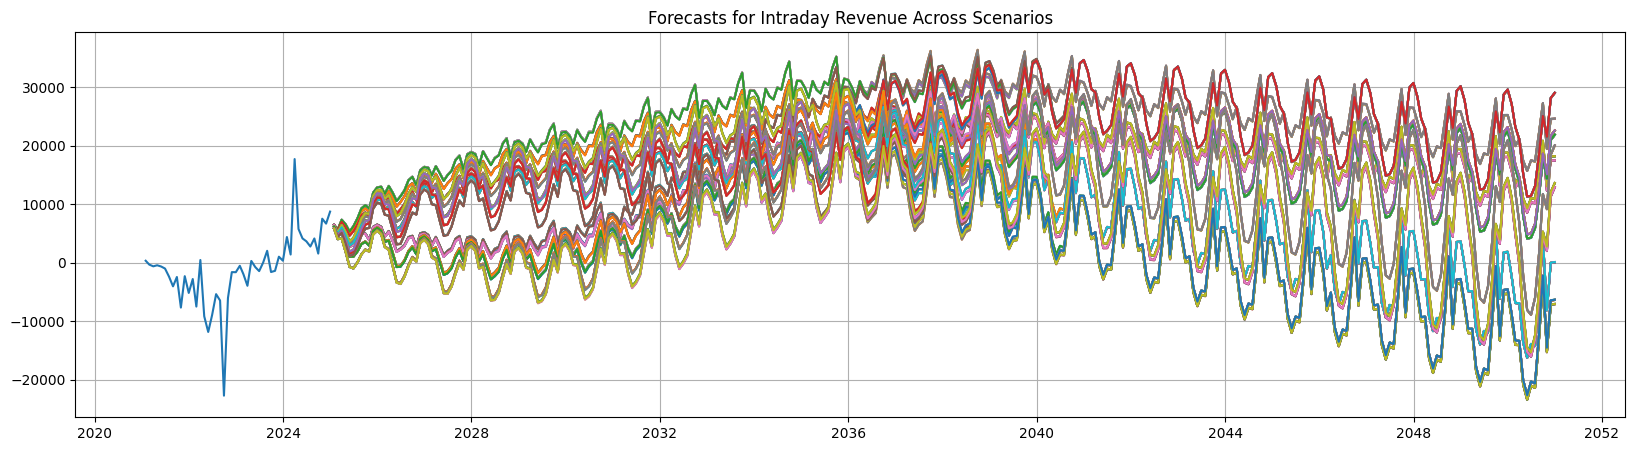

✅ Best Alpha: 13.219411484660288
✅ Mean Absolute Error on Full Data: 5185.0494


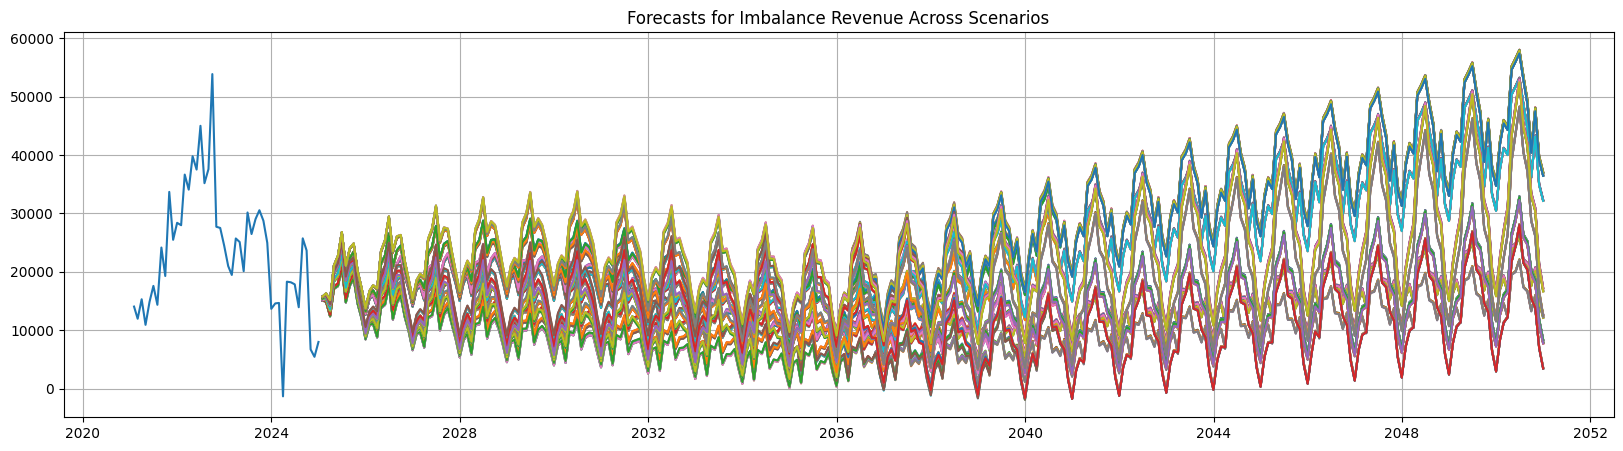

✅ Best Alpha: 1000.0
✅ Mean Absolute Error on Full Data: 236.3549


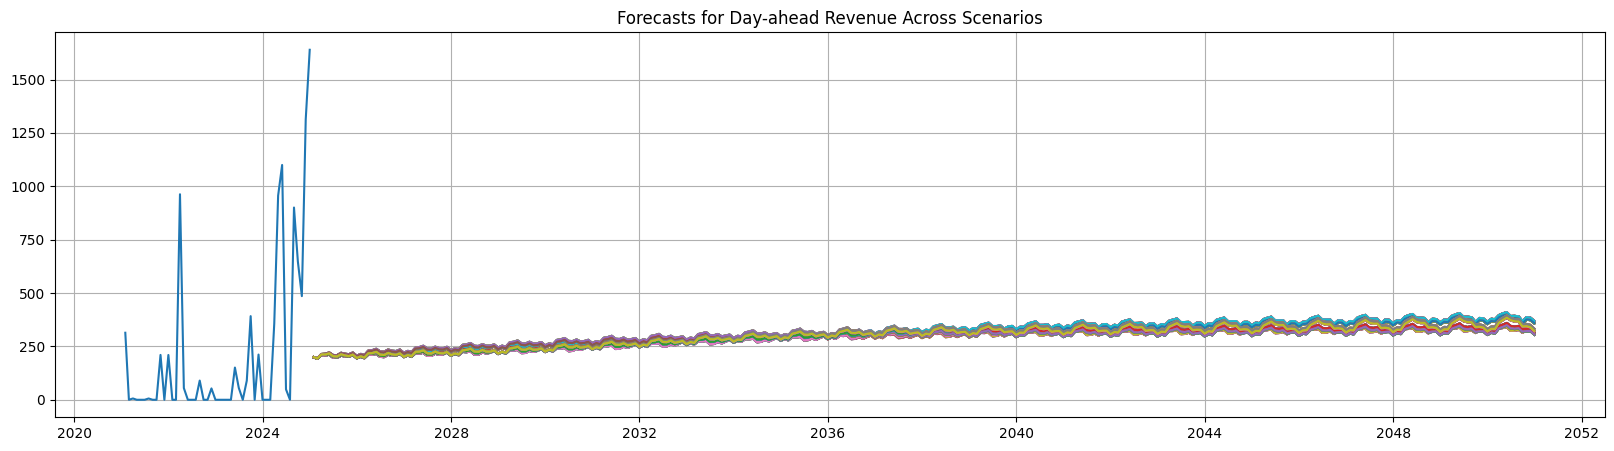

In [5]:
model, residuals, scaler = train_model(outcome="Intraday", show_summary=True, scale=False)
forecasts_id = forecast_with_scenarios(model, residuals, scaler, outcome="Intraday", add_volatility=False)

model, residuals, scaler = train_model(outcome="Imbalance", show_summary=True)
forecasts_im = forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance", add_volatility=False)

model, residuals, scaler = train_model(outcome="Day-ahead", show_summary=True)
forecasts_da = forecast_with_scenarios(model, residuals, scaler, outcome="Day-ahead", add_volatility=False)

# Combining Forecasts

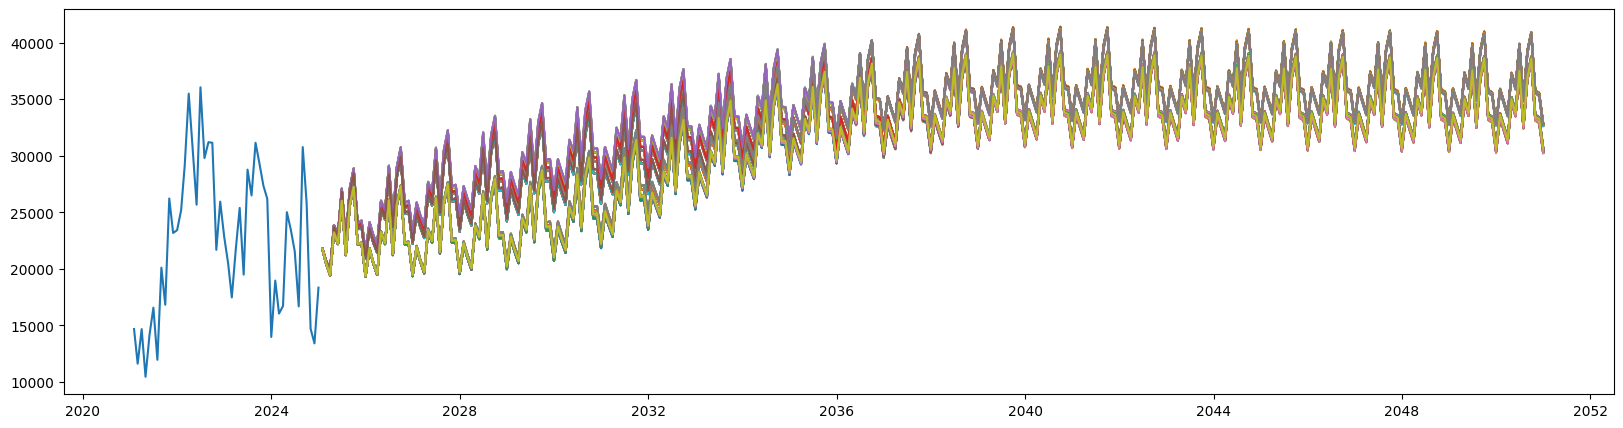

In [6]:
total_revenue = pd.DataFrame(index = forecasts_im.index, columns = forecasts_da.columns)
total_revenue.index.name = "Date"

for i in range(len(total_revenue.columns)):
    total_revenue.iloc[:, i] = forecasts_im.iloc[:, i] + forecasts_da.iloc[:, i] + forecasts_id.iloc[:, i]

# Plot historical data
plt.figure(figsize=(20, 5))
plt.plot(historical_data.index, historical_data["Total"], label="Historical Revenue")

for column in total_revenue.columns:
    plt.plot(total_revenue.index, total_revenue[column], label=column)
plt.show()

# Annualising and Scenario Building

Scenario low_low_low processed.
Scenario low_low_mid processed.
Scenario low_low_high processed.
Scenario low_mid_low processed.
Scenario low_mid_mid processed.
Scenario low_mid_high processed.
Scenario low_high_low processed.
Scenario low_high_mid processed.
Scenario low_high_high processed.
Scenario mid_low_low processed.
Scenario mid_low_mid processed.
Scenario mid_low_high processed.
Scenario mid_mid_low processed.
Scenario mid_mid_mid processed.
Scenario mid_mid_high processed.
Scenario mid_high_low processed.
Scenario mid_high_mid processed.
Scenario mid_high_high processed.
Scenario high_low_low processed.
Scenario high_low_mid processed.
Scenario high_low_high processed.
Scenario high_mid_low processed.
Scenario high_mid_mid processed.
Scenario high_mid_high processed.
Scenario high_high_low processed.
Scenario high_high_mid processed.
Scenario high_high_high processed.


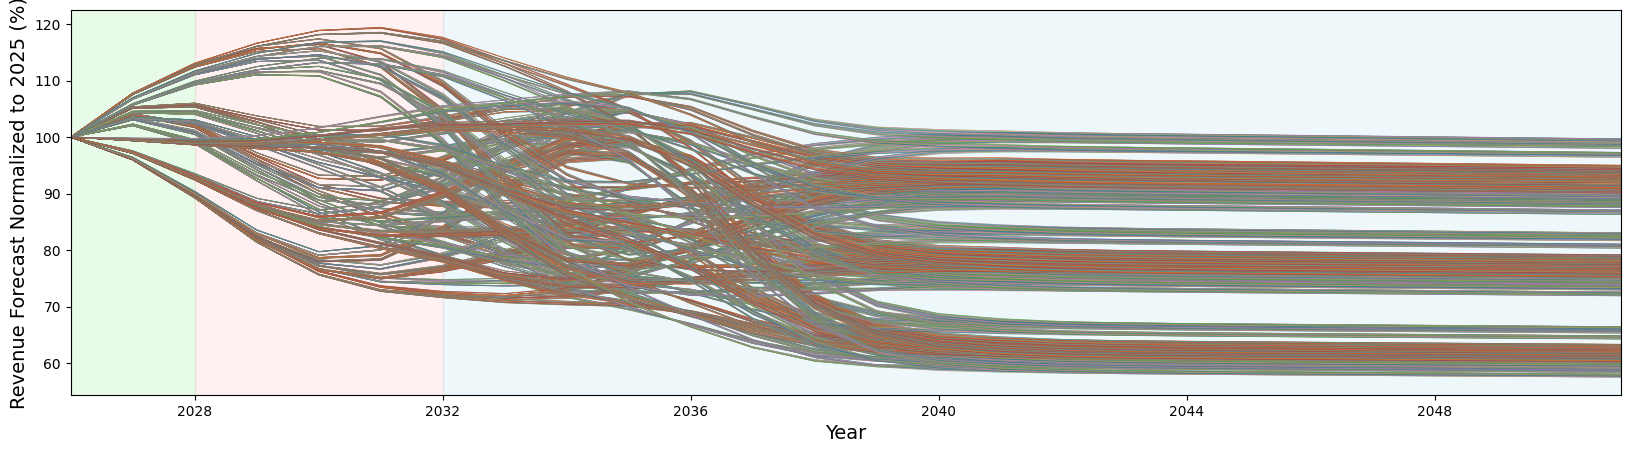

In [7]:
base = ["low", "mid", "high"]

# create combinations of scenarios
scenarios = []
for i in range(len(base)):
    for j in range(len(base)):
        for k in range(len(base)):
            scenarios.append(f"{base[i]}_{base[j]}_{base[k]}")

low_factors = [0.65, 0.5, 0.4]
mid_factors = [0.75, 0.6, 0.5]
high_factors = [0.95, 0.75, 0.6]

tipping_points = ["2028-01-01", "2032-01-01", "2036-01-01"]

create_annualized_forecast(scenarios, low_factors, mid_factors, high_factors, tipping_points, total_revenue)